In [58]:
# Call the library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor


from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import mean_absolute_error

sns.set(style='white', context='notebook', palette='deep')

In [2]:
df = pd.read_csv('./predict_delivery_time.csv')

In [3]:
df.head()

,Restaurant,Location,Cuisines,AverageCost,MinimumOrder,Rating,Votes,Reviews,DeliveryTime
0,ID6321,"FTI College, Law College Road, Pune","Fast Food, Rolls, Burger, Salad, Wraps",200,50,3.5,12.0,4.0,30
1,ID2882,"Sector 3, Marathalli","Ice Cream, Desserts",100,50,3.5,11.0,4.0,30
2,ID1595,Mumbai Central,"Italian, Street Food, Fast Food",150,50,3.6,99.0,30.0,65
3,ID5929,"Sector 1, Noida","Mughlai, North Indian, Chinese",250,99,3.7,176.0,95.0,30
4,ID6123,"Rmz Centennial, I Gate, Whitefield","Cafe, Beverages",200,99,3.2,521.0,235.0,65


In [60]:
df["DeliveryTime"].value_counts()

30     7236
45     2302
65      770
120      53
20       20
80       11
10        4
Name: DeliveryTime, dtype: int64

### Features
- Restaurant: A unique ID that represents a restaurant.
- Location: The location of the restaurant.
- Cuisines: The cuisines offered by the restaurant.
- Average_Cost: The average cost for one person/order.
- Minimum_Order: The minimum order amount.
- Rating: Customer rating for the restaurant.
- Votes: The total number of customer votes for the restaurant.
- Reviews: The number of customer reviews for the restaurant.
- Delivery_Time: The order delivery time of the restaurant. (Target Classes)

### 데이터셋 확인

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11094 entries, 0 to 11093
Data columns (total 9 columns):
Restaurant      11094 non-null object
Location        11094 non-null object
Cuisines        11094 non-null object
AverageCost     11094 non-null object
MinimumOrder    11094 non-null int64
Rating          9903 non-null object
Votes           9020 non-null float64
Reviews         8782 non-null float64
DeliveryTime    11094 non-null int64
dtypes: float64(2), int64(2), object(5)
memory usage: 780.1+ KB


In [36]:
df.describe()

,MinimumOrder,Votes,Reviews,DeliveryTime
count,11094.000000,9020.000000,8782.000000,11094.000000
mean,53.344511,244.544457,123.247893,37.056066
std,18.551245,555.094733,321.025216,12.447496
min,0.000000,3.000000,1.000000,10.000000
25%,50.000000,19.000000,7.000000,30.000000
50%,50.000000,63.000000,26.000000,30.000000
75%,50.000000,216.000000,91.000000,45.000000
max,500.000000,9054.000000,6504.000000,120.000000


## Data Preprocessing

In [4]:
# column 별 데이터 중 float 가 아닌 raw 들을 제외한 raw 만을 새로운 데이터프레임으로 생성
def change_nonint(df, col,types):
    L = []
    temp = df
    for i in df[col].unique():
        try:
            i = float(i)
        except:
            L.append(i)
    for i in L:
        temp = temp[temp[col] != i]
    temp = temp.astype({col:types})
    return temp

In [5]:
# ',' 제거
df['AverageCost'] = df['AverageCost'].apply(lambda x: x.replace(',', ''))

In [6]:
# str 인 값들 제거한 dataframe
# 이를 활용하여 outlier 계산
temp_df = df.copy()
num_columns = ['AverageCost', 'MinimumOrder',
       'Rating', 'Votes', 'Reviews']
for i in num_columns:
    temp_df = change_nonint(temp_df, i, 'float')

In [7]:
# Outlier detection

def detect_outliers(df, n, features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers
    according to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = df[col].quantile(.25)
        # 3rd quartile (75%)
        Q3 = df[col].quantile(.75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n)
    return multiple_outliers
    
# detect outliers from Age, SibSp, Parch and Fare
Outliers_to_drop = detect_outliers(temp_df, 2, ['AverageCost', 'MinimumOrder',
       'Rating', 'Votes', 'Reviews'])

In [8]:
df.loc[Outliers_to_drop]

,Restaurant,Location,Cuisines,AverageCost,MinimumOrder,Rating,Votes,Reviews,DeliveryTime
7,ID745,Delhi UniversityGTB Nagar,"Chinese, Thai, Asian",650,50,4.0,1731.0,1235.0,45
11,ID1696,"Yerawada, Pune, Maharashtra","Chinese, Thai, Indonesian, Italian",800,50,4.2,1693.0,1239.0,45
35,ID1160,"Sector 1, Noida","Asian, Burmese, Bubble Tea, Desserts, Salad, T...",600,50,4.7,914.0,499.0,45
80,ID7753,"Sandhurst Road, Mumbai CST Area","European, Continental, North Indian, Desserts",750,50,4.3,3124.0,1660.0,45
123,ID2885,"Nathan Road, Mangaldas Road, Pune","German, Italian, Cafe",450,50,4.3,4691.0,2547.0,45
167,ID1316,"Delhi High Court, India Gate","Cafe, Italian",600,50,4.2,2653.0,1581.0,65
197,ID2041,"Yerawada, Pune, Maharashtra","Italian, Pizza, Salad, Healthy Food, Mexican, ...",650,50,4.4,3248.0,1603.0,45
203,ID4878,"Mico Layout, Stage 2, BTM Layout,Bangalore","Cafe, Continental, Italian",400,50,4.2,2828.0,1443.0,45
205,ID2814,"Delhi High Court, India Gate","Japanese, Sushi, Asian",800,50,4.2,721.0,390.0,45
272,ID826,"Mico Layout, Stage 2, BTM Layout,Bangalore","Chinese, Sushi, Asian, Thai",650,50,4.4,925.0,589.0,30


In [9]:
# Drop outliers
temp_df = temp_df.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)
df = df.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

In [10]:
df.isnull().sum(), temp_df.isnull().sum()

(Restaurant         0
 Location           0
 Cuisines           0
 AverageCost        0
 MinimumOrder       0
 Rating          1191
 Votes           2074
 Reviews         2312
 DeliveryTime       0
 dtype: int64, Restaurant         0
 Location           0
 Cuisines           0
 AverageCost        0
 MinimumOrder       0
 Rating          1191
 Votes           1304
 Reviews         1540
 DeliveryTime       0
 dtype: int64)

In [11]:
df.info(), temp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10396 entries, 0 to 10395
Data columns (total 9 columns):
Restaurant      10396 non-null object
Location        10396 non-null object
Cuisines        10396 non-null object
AverageCost     10396 non-null object
MinimumOrder    10396 non-null int64
Rating          9205 non-null object
Votes           8322 non-null float64
Reviews         8084 non-null float64
DeliveryTime    10396 non-null int64
dtypes: float64(2), int64(2), object(5)
memory usage: 731.0+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9624 entries, 0 to 9623
Data columns (total 9 columns):
Restaurant      9624 non-null object
Location        9624 non-null object
Cuisines        9624 non-null object
AverageCost     9624 non-null float64
MinimumOrder    9624 non-null float64
Rating          8433 non-null float64
Votes           8320 non-null float64
Reviews         8084 non-null float64
DeliveryTime    9624 non-null int64
dtypes: float64(5), int64(1), object(3)
memory

(None, None)

In [240]:
temp_df.corr()

,AverageCost,MinimumOrder,Rating,Votes,Reviews,DeliveryTime
AverageCost,1.000000,0.053993,0.219185,0.114081,0.151690,0.108605
MinimumOrder,0.053993,1.000000,-0.000072,0.010255,0.000250,0.224980
Rating,0.219185,-0.000072,1.000000,0.365898,0.373281,0.078186
Votes,0.114081,0.010255,0.365898,1.000000,0.935987,0.154767
Reviews,0.151690,0.000250,0.373281,0.935987,1.000000,0.125434
DeliveryTime,0.108605,0.224980,0.078186,0.154767,0.125434,1.000000


In [13]:
# Location and Cuisines groupby mean
Lo_Cu_group = temp_df.groupby(['Location', 'Cuisines']).mean().reset_index()

In [12]:
str_AverageCost = ['for']
str_Rating = ['NEW', 'Opening Soon', 'Temporarily Closed']

In [14]:
for i in str_AverageCost:
    index_str_avgcost = list(df[df['AverageCost'] == i].index)
    for j in index_str_avgcost:
        avgcost_mean = round(temp_df['AverageCost'].mean(),1)
        if len(Lo_Cu_group[Lo_Cu_group['Location']==df.iloc[j]["Location"]][Lo_Cu_group['Cuisines']==df.iloc[j]["Cuisines"]]['AverageCost']) == 0:
            avgcost_pred = avgcost_mean
        else:
            avgcost_pred = round(Lo_Cu_group[Lo_Cu_group['Location']==df.iloc[j]["Location"]][Lo_Cu_group['Cuisines']==df.iloc[j]["Cuisines"]]['AverageCost'].iloc[0],1)

        if not np.isnan(avgcost_pred):
            df['AverageCost'].iloc[j] = avgcost_pred
        else:
            df['AverageCost'].iloc[j] = avgcost_mean
            
df = df.astype({"AverageCost":float})

C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\leejy\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [16]:
for i in str_Rating:
    index_str_rat = list(df[df['Rating'] == i].index)
    for j in index_str_rat:
        rating_mean = round(temp_df['Rating'].mean(),1)
        if len(Lo_Cu_group[Lo_Cu_group['Location']==df.iloc[j]["Location"]][Lo_Cu_group['Cuisines']==df.iloc[j]["Cuisines"]]['Rating']) == 0:
            rating_pred = rating_mean
        else:
            rating_pred = round(Lo_Cu_group[Lo_Cu_group['Location']==df.iloc[j]["Location"]][Lo_Cu_group['Cuisines']==df.iloc[j]["Cuisines"]]['Rating'].iloc[0],1)

        if not np.isnan(rating_pred):
            df['Rating'].iloc[j] = rating_pred
        else:
            df['Rating'].iloc[j] = rating_mean
            
df = df.astype({'Rating':float})

C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be r

C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will b

C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be r

C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be r

C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will b

C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will b

C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be r

C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be r

C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will b

C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will b

C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will b

C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will b

C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be r

C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be r

C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will b

C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will b

C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be r

C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will b

C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will b

C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be r

C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key wil

C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will b

C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\leejy\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will b

In [18]:
# 이 함수는 char 를 제외하고 나머지 3개의 nan value 를 변경할때만 사용가능
# char 를 대신해서 값을 채워주는 부분은 위에 부분으로 해결해야 함. 

# Filling missing value of Column
## Fill Rating with the mean Rating of similar rows according to Location and Cuisines
# Index of NaN Rating rows: index
def change_value(df, col, index):    
    for i in index:        
        col_mean = round(df[col].mean(),1)        
        col_pred = round(df[col][((df["Location"] == df.iloc[i]["Location"]) 
                                    & (df['Cuisines'] == df.iloc[i]["Cuisines"]) 
                                    )].mean(),1)
        if not np.isnan(col_pred):
            df[col].iloc[i] = col_pred
        else:
            df[col].iloc[i] = col_mean
    return df

In [19]:
# 반복문 3 가지를 함수로 해결한 것

index_NaN_vote = list(df["Votes"][df["Votes"].isnull()].index)
df = change_value(df, 'Votes', index_NaN_vote)

index_NaN_rat = list(df["Rating"][df["Rating"].isnull()].index)
df = change_value(df, 'Rating', index_NaN_rat)

index_NaN_review = list(df["Reviews"][df["Reviews"].isnull()].index)
df = change_value(df, 'Reviews', index_NaN_review)


In [20]:
# Drop useless variables
df.drop(labels = ["Restaurant"], axis =1, inplace = True)
# Make One-hot encoding
df = pd.get_dummies(df,columns = ["Location"], prefix="Lo")
df = pd.get_dummies(df,columns = ["Cuisines"], prefix="Cu")

In [47]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=2)
X_train = train_set.drop("DeliveryTime", axis=1)
Y_train = train_set["DeliveryTime"].copy()
X_test = test_set.drop("DeliveryTime", axis = 1)

In [49]:
# 절대값이 0.05 보다 큰 경우만 선택
corr_matrix = df.corr()
corr_matrix["DeliveryTime"].sort_values(ascending=False)

DeliveryTime                                          1.000000
MinimumOrder                                          0.228647
Votes                                                 0.152508
Reviews                                               0.125587
Cu_Bakery, Continental, Pizza, Desserts               0.118407
AverageCost                                           0.117009
Cu_Bakery, Desserts                                   0.112247
Rating                                                0.078884
Cu_Bakery                                             0.073441
Cu_Fast Food, North Indian, Biryani, Rolls, Wraps     0.068966
Cu_Bakery, Desserts, Beverages, Fast Food             0.068356
Cu_Burger, Pizza, Sandwich                            0.068356
Cu_Bakery, Italian, Desserts, Sandwich                0.068356
Cu_Bakery, Desserts, Fast Food, North Indian          0.068356
Cu_Bakery, Desserts, Fast Food                        0.068341
Cu_Bakery, Fast Food, Desserts                        0

In [51]:
new_col= [
"MinimumOrder",
"Votes",
"Reviews",
"Cu_Bakery, Continental, Pizza, Desserts",
"AverageCost",
"Cu_Bakery, Desserts",
"Rating",
"Cu_Bakery",
"Cu_Fast Food, North Indian, Biryani, Rolls, Wraps",
"Cu_Bakery, Desserts, Beverages, Fast Food",
"Cu_Burger, Pizza, Sandwich",
"Cu_Bakery, Italian, Desserts, Sandwich",
"Cu_Bakery, Desserts, Fast Food, North Indian",
"Cu_Bakery, Desserts, Fast Food",
"Cu_Bakery, Fast Food, Desserts",
"Lo_Sector 63A,Gurgaon",
"Cu_Mishti, Fast Food, South Indian",
"Lo_Delhi High Court, India Gate",
"Cu_North Indian, Biryani, Mughlai, Kebab",
"Cu_Chinese, North Indian, Thai, Fast Food, Seafood",
  "Lo_FTI College, Law College Road, Pune",
"Lo_Babarpur, New Delhi, Delhi"
  ]

X_train_select = X_train[new_col]
X_test_select = X_test[new_col]

## 아래 코드는 작동이 되지 않는다.
- One-hot encoding 시, train set 에 있는 범주 내에 없는 값이 test-set 에 나오기 때문인듯!!
- 따라서 One-hot encoding 을 진행한 후에 데이터셋으로 Pipeline 을 시도한다.

In [44]:
# cat_attribs  = ["Location", "Cuisines"] # 범주형
# num_attribs = ["MinimumOrder","Votes","Reviews","Rating", "AverageCost"] # 수치형 columns 의 Name 만을 list 로 변환


# num_pipeline_robust = Pipeline([
#         ('robust_scaler', RobustScaler()),
#     ])
# num_pipeline_minmax = Pipeline([
#         ('minmax_scaler', MinMaxScaler()),
#     ])



# full_pipeline_robust = ColumnTransformer([
#         ("num", num_pipeline_robust, num_attribs), # ("이름", "파이프라인", 파이프라인을 적용할 feature 들)
#         ("cat", OneHotEncoder(), cat_attribs), # missing value 가 없었기에 imputer 가 필요없고  새로운 attribute 를 생성한 것이 없으므로 attribe_adder 도 필요없다.
#                                                 # 오직 standardscaler 가 아닌 category column 을 위한 OneHotEncoder 만을 사용한 것
#     ])

# full_pipeline_minmax = ColumnTransformer([
#         ("num", num_pipeline_minmax, num_attribs), # ("이름", "파이프라인", 파이프라인을 적용할 feature 들)
#         ("cat", OneHotEncoder(), cat_attribs), # missing value 가 없었기에 imputer 가 필요없고  새로운 attribute 를 생성한 것이 없으므로 attribe_adder 도 필요없다.
#                                                 # 오직 standardscaler 가 아닌 category column 을 위한 OneHotEncoder 만을 사용한 것
#     ])

# train_scaled_robust = full_pipeline_robust.fit_transform(train_set)
# train_scaled_minmax = full_pipeline_minmax.fit_transform(train_set)
# # Error 발생
# # train_set 에 없는 category 값 중 test_set 에 있는 값이 존재하기에 발생하는 듯
# test_scaled_robust = full_pipeline_robust.transform(test_set)
# test_scaled_minmax = full_pipeline_minmax.transform(test_set)


C:\Users\leejy\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


ValueError: Found unknown categories ['American, Asian, European', 'Chinese, North Indian, Desserts', 'Mediterranean, Italian', 'Biryani, Andhra, Chinese', 'Fast Food, Wraps, Sandwich, Burger, Beverages', 'South Indian, Chinese, Biryani', 'Chinese, Fast Food, North Indian, Continental', 'Sandwich, Pizza, Finger Food, Burger, Wraps', 'North Indian, South Indian, Chinese, Continental', 'Healthy Food, Sandwich, Beverages, Desserts', 'North Indian, Biryani, Maharashtrian', 'Chinese, Asian, Momos', 'Cafe, Chinese, Desserts', 'Chinese, Mughlai, North Indian, Biryani, Raw Meats', 'Chinese, Momos, Thai', 'Mexican, Italian, Continental, Desserts, Beverages', 'Andhra, Hyderabadi, Biryani, South Indian, North Indian, Rolls, Mughlai', 'Bengali, Mughlai, Awadhi, North Indian, South Indian, Chinese, Biryani', 'Chinese, Rolls, North Indian', 'Pizza, Italian, Fast Food, Bakery', 'Continental, Fast Food, American', 'Italian, Healthy Food, Wraps', 'North Indian, Fast Food, South Indian, Biryani, Sandwich, Juices, Rolls, Healthy Food', 'Chinese, Fast Food, Desserts', 'Chinese, Continental, Burger, Pizza', 'Healthy Food, Fast Food, Beverages', 'Continental, Chinese, North Indian', 'Cafe, Pizza, North Indian', 'Rolls, North Indian, Mughlai', 'Wraps, North Indian, Biryani, Fast Food', 'Frozen Yogurt, Fast Food, Desserts, Beverages', 'Maharashtrian, Fast Food, Street Food, Sandwich', 'Bengali, Chinese, Rolls, North Indian, Odia, Seafood', 'Beverages, Juices, Fast Food, Desserts', 'Mughlai, Kebab', 'Chinese, American', 'Asian, Chinese, Fast Food', 'Mexican, Italian, Modern Indian', 'Pizza, Bakery', 'Italian, Beverages, Pizza', 'North Indian, Chinese, South Indian, Mithai', 'Beverages, Juices, Ice Cream', 'Mithai, Desserts, Street Food', 'Seafood, Biryani, North Indian, Chinese, Arabian, Charcoal Chicken, Kerala', 'Cafe, Desserts, Fast Food', 'Healthy Food, Beverages, Fast Food', 'Biryani, Kebab, Healthy Food', 'Fast Food, Chinese, Mughlai, Rolls', 'South Indian, North Indian, Chinese, Desserts, Beverages', 'Pizza, Italian, Salad', 'Chinese, Indian, North Indian, Mughlai', 'Malaysian, Asian', 'North Indian, Continental, Chinese, Italian, Mexican', 'Chinese, Fast Food, North Indian, South Indian', 'South Indian, Street Food, Seafood', 'Hyderabadi, North Indian, Chinese, Biryani', 'Finger Food, Bar Food, Italian, North Indian, Asian, Continental', 'Gujarati', 'Burger, Rolls', 'North Indian, Street Food, Momos', 'Bakery, Desserts, Salad, Pizza, Beverages, Cafe, Fast Food, Continental', 'Street Food, South Indian, Ice Cream, Beverages', 'Andhra, South Indian, Hyderabadi', 'Continental, Italian, BBQ', 'Fast Food, Chinese, Italian, Seafood, Beverages', 'Fast Food, Burger, Italian, Beverages', 'Biryani, Street Food', 'South Indian, Desserts', 'Bengali, Biryani, Chinese', 'Bengali, North Indian, Chinese, Biryani', 'Fast Food, Chinese, Asian, Thai', 'Pizza, Sandwich', 'South Indian, Chettinad, Chinese', 'North Indian, Mughlai, Biryani, Chinese', 'Middle Eastern, Lebanese, Healthy Food', 'Beverages, Fast Food, Desserts', 'Fast Food, Chinese, South Indian, Rolls', 'Fast Food, Pizza, Burger, Beverages', 'North Indian, Chinese, Kebab, Rolls', 'Mughlai, Rolls', 'North Indian, Bengali, Chinese', 'Bakery, Ice Cream, Coffee', 'Salad, North Indian, Biryani, Desserts, Beverages, Wraps', 'Chinese, Continental, North Indian, South Indian', 'Pizza, Chinese, North Indian', 'Raw Meats, Fast Food', 'Chinese, Thai, Tibetan, Japanese, Momos', 'Momos, Street Food, Fast Food, Tibetan, Chinese', 'North Indian, Continental, Chinese, Fast Food', 'North Indian, Chinese, Kebab, Momos, Burger, Rolls, Biryani', 'Continental, Asian, Italian', 'North Indian, Chinese, Malwani, Mexican', 'Rolls, North Indian, Chinese, Momos, Biryani', 'South Indian, North Indian, Chinese, Seafood', 'North Indian, Biryani, Hyderabadi, Mughlai', 'North Indian, South Indian, Chinese, Bakery', 'Chinese, North Indian, Kerala, Seafood, Fast Food', 'Bakery, Healthy Food, Fast Food', 'Burger, Sandwich, Finger Food', 'Kebab, Biryani, North Indian', 'Street Food, Gujarati', 'Cafe, Coffee, Tea, Desserts', 'North Indian, Pizza, Burger, Continental', 'North Indian, Tea', 'Juices, Sandwich, Burger, Beverages, Continental', 'Chinese, Continental, North Indian, Kebab, Seafood, Italian, Desserts', 'North Indian, Chinese, Bengali, Fast Food', 'Lebanese, Biryani, Wraps, Rolls, Kebab', 'North Indian, Chinese, Street Food, Juices', 'Biryani, Andhra, North Indian, Seafood', 'Biryani, North Indian, Chinese, Andhra, South Indian', 'North Indian, Chinese, Rolls, Momos, Fast Food', 'North Indian, Rolls, Chinese, Biryani', 'North Indian, Mughlai, Rajasthani, Biryani', 'Chinese, North Indian, Mughlai, Desserts, Momos', 'North Indian, Cafe, Fast Food, Beverages', 'North Indian, Chinese, South Indian, Street Food', 'North Indian, Rolls, Street Food', 'Asian, Chinese, Momos, Thai', 'North Indian, Fast Food, Chinese, Beverages', 'South Indian, Continental', 'North Indian, Mithai', 'Italian, TexMex, Bakery', 'South Indian, Kerala, Beverages', 'Korean, Momos, Asian', 'Cafe, Beverages, Italian, Chinese', 'Pizza, Burger, Fast Food, Beverages', 'Raw Meats, North Indian', 'Cafe, Continental, Mexican', 'Cafe, Fast Food, Pizza', 'North Indian, Asian, Biryani, Mughlai, Desserts, Kashmiri', 'Healthy Food, Chinese', 'Chinese, Fast Food, Beverages, North Indian', 'Healthy Food, North Indian, Thai', 'Fast Food, North Indian, Rolls', 'Fast Food, Sandwich, Beverages', 'Beverages, Salad, Desserts, Juices', 'North Indian, South Indian, Thai', 'Chinese, Asian, Thai, Vietnamese, Momos', 'Rajasthani, Gujarati, Beverages, Desserts, North Indian', 'South Indian, North Indian, Chinese, Sandwich, Continental, Desserts, Beverages', 'North Indian, Chinese, Mughlai, Pizza, Fast Food, Street Food, Desserts', 'Biryani, North Indian, Mughlai, Kebab', 'Mexican, Chinese, North Indian', 'Momos, Fast Food, Tea', 'Cafe, Healthy Food, Sandwich, North Indian, Wraps, Salad, Street Food, Beverages', 'Healthy Food, Salad, Lebanese', 'North Indian, Asian, Healthy Food', 'Desserts, Fast Food, Beverages', 'Continental, Italian, Lebanese, Desserts, Beverages', 'Cafe, Fast Food, Italian', 'Desserts, Street Food, Sandwich, Beverages', 'Pizza, Fast Food, Burger, Beverages', 'North Indian, Mughlai, Biryani, Bengali', 'Continental, Chinese, Fast Food, Momos', 'North Indian, Fast Food, Beverages, Ice Cream, South Indian, Desserts', 'Bakery, Desserts, Mithai', 'Fast Food, North Indian, Biryani', 'Cafe, American, Asian, North Indian', 'Fast Food, Sandwich, Burger, Beverages', 'Italian, Continental, Beverages', 'Modern Indian, Bar Food, North Indian, Continental', 'North Indian, Chinese, Fast Food, Rolls, Juices', 'Street Food, Chinese, North Indian, Mithai', 'Salad, Continental, Fast Food, Italian, Pizza', 'Bar Food, Italian, Chinese', 'Fast Food, Healthy Food, Burger, Rolls', 'North Indian, Cafe, Mexican', 'Chinese, Street Food, Beverages', 'Momos, Tibetan', 'Andhra, South Indian, North Indian, Biryani, Chinese, Beverages', 'Kerala, Seafood, Chinese', 'North Indian, Rolls, Fast Food', 'South Indian, Hyderabadi', 'South Indian, Chinese, Mangalorean', 'Mithai, South Indian, Street Food, Chinese, Fast Food, North Indian', 'South Indian, Chinese, Street Food, Mithai', 'North Indian, Mughlai, Chinese, Continental', 'Beverages, Rolls, Biryani, BBQ', 'Maharashtrian, Seafood', 'Beverages, Ice Cream, Fast Food, Juices, Desserts', 'Fast Food, Biryani', 'Street Food, Fast Food, Beverages, Desserts, Mithai', 'Chinese, Tibetan, Momos', 'Momos, Chinese', 'Salad, Healthy Food, Sandwich, Juices, Burger, Desserts, Pizza', 'Biryani, Mughlai, Chinese', 'Momos, Ice Cream', 'Biryani, North Indian, Chinese, Rolls', 'Tamil, Biryani, Chettinad, North Indian, Chinese, South Indian', 'Beverages, Lebanese, Arabian', 'Beverages, Juices, North Indian', 'Healthy Food, Salad, Mexican, Beverages', 'Desserts, Ice Cream, Bakery', 'North Indian, Mithai, Rajasthani, Desserts', 'Healthy Food, Salad, North Indian, Continental, Beverages', 'South Indian, North Indian, Street Food, Fast Food', 'Bakery, Mithai, Fast Food', 'Fast Food, Burger, Chinese, Beverages', 'Pizza, Burger, Fast Food, Desserts', 'American, Continental, Burger, Italian, Pizza, Beverages', 'Fast Food, Burger, Desserts', 'North Indian, Fast Food, Mithai', 'North Indian, Malwani, Biryani', 'Fast Food, Chinese, Burger, Sandwich, Wraps, Beverages, Desserts', 'North Indian, Maharashtrian, Konkan', 'Chinese, Tibetan, North Indian, Momos', 'Continental, Beverages, Healthy Food', 'Kerala, Chinese, South Indian, North Indian', 'Bengali, Seafood, North Indian, Biryani, Odia', 'North Indian, Chinese, Fast Food, Momos', 'North Indian, Chinese, Biryani, Street Food', 'South Indian, North Indian, Chinese, Street Food, Beverages', 'Chinese, North Indian, South Indian, Mughlai', 'North Indian, Street Food, Juices', 'Pizza, Continental, Italian, Fast Food'] in column 1 during transform

In [52]:
num_attribs = ["MinimumOrder","Votes","Reviews","Rating", "AverageCost"] # 수치형 columns 의 Name 만을 list 로 변환


num_pipeline_robust = Pipeline([
         ('robust_scaler', RobustScaler()),
     ])
num_pipeline_minmax = Pipeline([
         ('minmax_scaler', MinMaxScaler()),
     ])
    
    
# One-hot encoding 된 전체 column 에 대하여 진행  by robust scaler and minmax scaler
X_train_full_scaled_robust = num_pipeline_robust.fit_transform(X_train)
X_train_full_scaled_minmax = num_pipeline_minmax.fit_transform(X_train)


# One-hot encoding 된 전체 column 중 corr() 의 절대값이 0.05 이상인 일부 column 을 select 해서 진행 by robust scaler and minmax scaler
X_train_select_scaled_robust = num_pipeline_robust.fit_transform(X_train_select)
X_train_select_scaled_minmax = num_pipeline_minmax.fit_transform(X_train_select)



C:\Users\leejy\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\leejy\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


## Modeling

In [75]:
# Modeling step Test differents algorithms
random_state = 2
regressions = []
regressions.append(LinearRegression())
regressions.append(RandomForestRegressor(n_estimators=100, random_state=random_state))
regressions.append(DecisionTreeRegressor(random_state=random_state))




def cv_result(regressions_list, train_data):
    cv_results = []
    for regression in regressions:
        cv_results.append(cross_val_score(regression, train_data, y=Y_train, scoring = 'neg_mean_absolute_error', cv = 10))
    return cv_results


cv_results_X_train_full_scaled_robust = cv_result(regressions, X_train_full_scaled_robust)
cv_results_X_train_full_scaled_minmax = cv_result(regressions, X_train_full_scaled_minmax)
cv_results_X_train_select_scaled_robust = cv_result(regressions, X_train_select_scaled_robust)
cv_results_X_train_select_scaled_minmax = cv_result(regressions, X_train_select_scaled_minmax)

def cv_res(cv_results):
    cv_means = []
    cv_std = []
    for cv_result in cv_results:
        cv_means.append(cv_result.mean())
        cv_std.append(cv_result.std())

    cv_res = pd.DataFrame({"CrossValMeans": cv_means, "CrossValerrors": cv_std, "Algorithm":["LinearRegression","RandomForestRegressor","DecisionTreeRegressor"]})
    return cv_res, cv_std

cv_res_full_robust, cv_res_full_robust_std = cv_res(cv_results_X_train_full_scaled_robust)
cv_res_full_minmax, cv_res_full_minmax_std = cv_res(cv_results_X_train_full_scaled_minmax)
cv_res_select_robust, cv_res_select_robust_std = cv_res(cv_results_X_train_select_scaled_robust)
cv_res_select_minmax, cv_res_select_minmax_std = cv_res(cv_results_X_train_select_scaled_minmax)

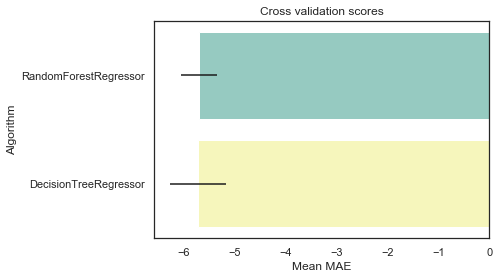

In [101]:
cv_res_full_robust = cv_res_full_robust[1:]
cv_res_full_robust_std = cv_res_full_robust_std[1:]
g = sns.barplot("CrossValMeans", "Algorithm", data = cv_res_full_robust, palette="Set3",
               orient = "h", **{'xerr':cv_res_full_robust_std}) 
g.set_xlabel("Mean MAE")
g = g.set_title("Cross validation scores")



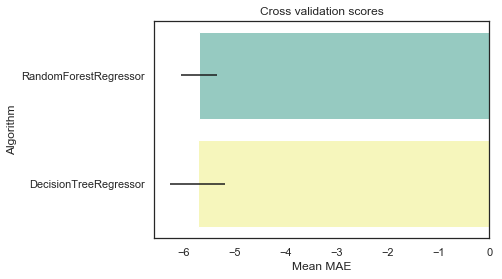

In [107]:
cv_res_full_minmax = cv_res_full_minmax[1:]
cv_res_full_minmax_std = cv_res_full_minmax_std[1:]

g = sns.barplot("CrossValMeans", "Algorithm", data = cv_res_full_minmax, palette="Set3",
               orient = "h", **{'xerr':cv_res_full_minmax_std}) 
g.set_xlabel("Mean MAE")
g = g.set_title("Cross validation scores")

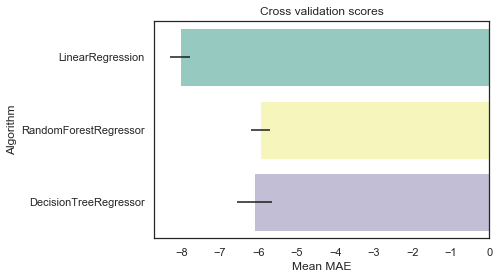

In [82]:
g = sns.barplot("CrossValMeans", "Algorithm", data = cv_res_select_robust, palette="Set3",
               orient = "h", **{'xerr':cv_res_select_robust_std}) 
g.set_xlabel("Mean MAE")
g = g.set_title("Cross validation scores")

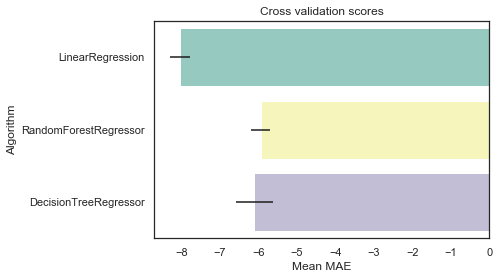

In [83]:
g = sns.barplot("CrossValMeans", "Algorithm", data = cv_res_select_minmax, palette="Set3",
               orient = "h", **{'xerr':cv_res_select_minmax_std}) 
g.set_xlabel("Mean MAE")
g = g.set_title("Cross validation scores")

### 성능 확인

- LinearRegression 을 제외한 두 가지 모델에선 ``MAE`` 를 보았을 땐 큰 차이가 나지 않았습니다.
- 이에 또 다른 지표로 ``under_prediction`` 을 사용하여 성능을 비교하였습니다.

In [138]:
y_pred_robust = cross_val_predict(regressions[1], X_train_full_scaled_robust, Y_train, cv=3)
y_pred_minmax = cross_val_predict(regressions[1], X_train_full_scaled_minmax, Y_train, cv=3)
y_pred_robust_dtr = cross_val_predict(regressions[2], X_train_full_scaled_robust, Y_train, cv=3)
y_pred_minmax_dtr = cross_val_predict(regressions[2], X_train_full_scaled_minmax, Y_train, cv=3)

In [148]:
def under_prediction(predict, label):
    cna    for i in predict - label:
        if i < 0 :
            cnt += 1
    return round(cnt / len(label),5) * 100

In [161]:
robust_rfr = under_prediction(y_pred_robust, Y_train)
minmax_rfr = under_prediction(y_pred_minmax, Y_train)
robust_dtr = under_prediction(y_pred_robust_dtr, Y_train)
minmax_dtr = under_prediction(y_pred_minmax_dtr, Y_train)

In [164]:
pred

,Under_prediction,Algorithm
0,27.549,RandomForestRegressor - Robust
1,27.549,RandomForestRegressor - MinMax
2,16.558,DecisionTreeRegressor - Robust
3,16.607,DecisionTreeRegressor - MinMax


In [162]:
pred = pd.DataFrame({"Under_prediction": [robust_rfr, minmax_rfr, robust_dtr, minmax_dtr],"Algorithm":["RandomForestRegressor - Robust",
                                                                                                       "RandomForestRegressor - MinMax",
                                                                                                       "DecisionTreeRegressor - Robust",
                                                                                                       "DecisionTreeRegressor - MinMax"
                                                                                                      ]})

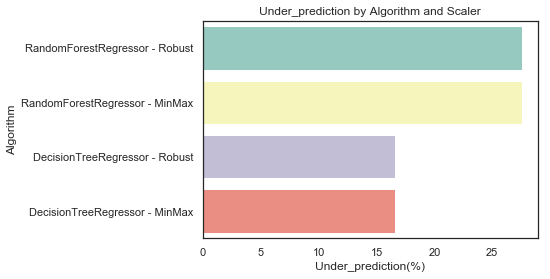

In [163]:
g = sns.barplot("Under_prediction", "Algorithm", data = pred, palette="Set3",
               orient = "h") 
g.set_xlabel("Under_prediction(%)")
g = g.set_title("Under_prediction by Algorithm and Scaler")

위의 그래프를 보아 ``DecisionTreeRegressor`` 이 ``RandomForestRegressor`` 보다 $11\%$ 가량 비율이 더 낮음을 볼 수 있습니다.

<br>

따라서, fine-tune 을 위한 최종 모델은 ``DecisionTreeRegressor`` 로 선정하였습니다.

또한 ``Robust_scaler`` 가 ``MinMax_scaler`` 보다 조금이나마 성능이 더 좋았기에 최종적인 ``train_data`` 는 ``Robust_scaler`` 로 선정하였습니다.

In [166]:
dt_reg = DecisionTreeRegressor(random_state=2)
param_grid = {
              "min_samples_split": [10, 20, 40],
              "max_depth": [6, 8],
              "min_samples_leaf": [20, 40],
              }


grid_cv_dtm = GridSearchCV(dt_reg, param_grid, cv=5,scoring='neg_mean_absolute_error',return_train_score=True)

grid_cv_dtm.fit(X_train_full_scaled_robust,Y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=2, splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'min_samples_split': [10, 20, 40], 'max_depth': [6, 8], 'min_samples_leaf': [20, 40]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=0)

In [167]:
from sklearn.metrics import mean_absolute_error

In [168]:
cvres = grid_cv_dtm.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

-7.356181150426495 {'max_depth': 6, 'min_samples_leaf': 20, 'min_samples_split': 10}
-7.356181150426495 {'max_depth': 6, 'min_samples_leaf': 20, 'min_samples_split': 20}
-7.356181150426495 {'max_depth': 6, 'min_samples_leaf': 20, 'min_samples_split': 40}
-7.3079293078543595 {'max_depth': 6, 'min_samples_leaf': 40, 'min_samples_split': 10}
-7.3079293078543595 {'max_depth': 6, 'min_samples_leaf': 40, 'min_samples_split': 20}
-7.3079293078543595 {'max_depth': 6, 'min_samples_leaf': 40, 'min_samples_split': 40}
-7.27866093354334 {'max_depth': 8, 'min_samples_leaf': 20, 'min_samples_split': 10}
-7.27866093354334 {'max_depth': 8, 'min_samples_leaf': 20, 'min_samples_split': 20}
-7.27866093354334 {'max_depth': 8, 'min_samples_leaf': 20, 'min_samples_split': 40}
-7.241019687810449 {'max_depth': 8, 'min_samples_leaf': 40, 'min_samples_split': 10}
-7.241019687810449 {'max_depth': 8, 'min_samples_leaf': 40, 'min_samples_split': 20}
-7.241019687810449 {'max_depth': 8, 'min_samples_leaf': 40, 'min_

In [169]:
final_model = grid_cv_dtm.best_estimator_


#X_test_full_scaled_robust = num_pipeline_robust.transform(X_test)
y_test = test_set["DeliveryTime"].copy()

final_predictions = final_model.predict(X_test_full_scaled_robust)

final_mae = mean_absolute_error(y_test, final_predictions)
final_Under_prediction = under_prediction(final_predictions, y_test)

In [170]:
final_mae, final_Under_prediction

(6.76436235749662, 25.673000000000002)